# Task Description

This notebook captures the task of aspect term extraction from the sentences meaning that the words which determine the category of the refering review are extracted. 

The basic IOB tagging, BERT model with IOB tagging and BERT model with binary tagging of the aspect terms were used as benchmarks for the BERT model with IOB tagging of the aspect terms. The advantage of the latter to the BERT model with binary tagging is that for multiple word aspect terms the IOB tagging indicates that the words belong to a same chunk. However, with the binary tagging the difference between (for example) a three-word aspect term and three consecutive aspect terms is not clear.

Every IOB tagging is made with nltk package and the BERT models are written with pyTorch using the pretrained BertForTokenClassification package.

## Packages

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 7.4MB/s 
     |████████████████████████████████| 890kB 20.8MB/s 
     |████████████████████████████████| 2.9MB 60.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=27a7a68ab783464128fe486d81ba6ce2ab27953bf469ff5c3db9b3ca542a8eaf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
pip install seqeval

     |████████████████████████████████| 51kB 3.0MB/s eta 0:00:011
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=f4ac780a91bfd1f0ac48ab7a502b1b507d9f6bff75aadd52b155b6ef151104b1
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
!pip install contractions

     |████████████████████████████████| 245kB 7.2MB/s 
     |████████████████████████████████| 317kB 33.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81693 sha256=023e9d0c4effb9c638ecf479d3ea755300f874fd01bb51f04af09b29da1c9fce
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
import contractions
import matplotlib.pyplot as plt
%matplotlib inline
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('english')
import numpy as np
import pandas as pd
import re
import seaborn as sns
import seqeval
import torch
import transformers

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import conlltags2tree, tree2conlltags
from seqeval.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import trange
from transformers import AdamW, BertTokenizer, BertForTokenClassification, get_linear_schedule_with_warmup

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index


## Data Processing

In [ ]:
# Import data
train = pd.read_excel('Trainset.xlsx')
test = pd.read_excel('Testset.xlsx')

# Eliminate the NAs
train = train.fillna('')
test = test.fillna('')

# Remove the rows without Opinion Category values
train = train[train.OpinionCategory != ''] 
test = test[test.OpinionCategory != ''] 

# Sort the data
train = train.sort_values('Sentence_ID').reset_index(drop=True)
test = test.sort_values('Sentence_ID').reset_index(drop=True)

train_Text = train.drop_duplicates(subset=['Sentence_ID'], keep='last').Text
test_Text = test.drop_duplicates(subset=['Sentence_ID'], keep='last').Text

train_df = pd.DataFrame(train_Text).reset_index(drop=True)
test_df = pd.DataFrame(test_Text).reset_index(drop=True)

aspect_list = []
for i in range((max(train.Sentence_ID))):
    if any(train.Sentence_ID == i+1) == True:
      aspect_list.append(train.groupby(['Sentence_ID']).get_group(i+1).AspectTerm.values)

aspect_list_test = []
for i in range((max(test.Sentence_ID))):
    if any(test.Sentence_ID == i+1) == True:
      aspect_list_test.append(test.groupby(['Sentence_ID']).get_group(i+1).AspectTerm.values)

train_df = pd.merge(train_df, pd.DataFrame({'aspectTerms': pd.Series(aspect_list)}), left_index = True, right_index=True).reset_index(drop=True)
test_df = pd.merge(test_df, pd.DataFrame({'aspectTerms': pd.Series(aspect_list_test)}), left_index = True, right_index=True).reset_index(drop=True)

train_df

,Text,aspectTerms
0,Judging from previous posts this used to be a ...,[place]
1,"We, there were four of us, arrived at noon - t...",[staff]
2,"They never brought us complimentary noodles, i...",[]
3,The food was lousy - too sweet or too salty an...,"[food, portions]"
4,"After all that, they complained to me about th...",[]
...,...,...
1703,"I can't believe that it was, but please put th...",[]
1704,The waitress came to check in on us every few ...,[waitress]
1705,I couldn't ignore the fact that she reach over...,[]
1706,She then put the check down without asking if ...,[]


## Data Cleaning

In [ ]:
def cleanText(text):
    text = contractions.fix(text) # fix the contractions (such as I've = I have)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # remove urls
    text = ''.join([i for i in text if not i.isdigit()]) # remove numbers
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text) # remove punctuations
    text = text.lower() # make lower case
    return text

In [ ]:
train_df.Text = train_df.Text.astype(str).map(lambda x: cleanText(x))
test_df.Text = test_df.Text.astype(str).map(lambda x: cleanText(x))

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## Tagging

### nltk IOB Tagging

The IOB format (short for inside, outside, beginning) is a  tagging format for tagging tokens in a chunking task (in this case, aspect term chunks)
- B: the beginning of a chunk
- I: the words inside a chunk
- O: for the tokens that belong to no chunk

In [ ]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [ ]:
# Train
train_df.Text = train_df.Text.astype('str')
sample = train_df.Text[0]
sent = preprocess(sample)

pattern = 'NP: {<DT>?<JJ>*<NN>}'
cp = nltk.RegexpParser(pattern)

cs = cp.parse(sent)
iob_tagged = tree2conlltags(cs)
df_sample = pd.DataFrame(iob_tagged, columns = ['Word', 'POS', 'nltkTag'])
df_sample.insert(0, 'Sentence #', 0+1)

for i in range(len(train_df.Text)-1):
  sample = train_df.Text[i+1]
  sent = preprocess(sample)
  cs = cp.parse(sent)
  iob_tagged = tree2conlltags(cs)
  other_samples = pd.DataFrame(iob_tagged, columns = ['Word', 'POS', 'nltkTag'])
  other_samples.insert(0, 'Sentence #', i+2)
  df_sample = pd.concat([df_sample, other_samples], axis=0)

df_sample = df_sample.reset_index(drop = True)
df_sample

,Sentence #,Word,POS,nltkTag
0,1,judging,VBG,O
1,1,from,IN,O
2,1,previous,JJ,O
3,1,posts,NNS,O
4,1,this,DT,O
...,...,...,...,...
21595,1708,someone,NN,I-NP
21596,1708,would,MD,O
21597,1708,retrain,VB,O
21598,1708,the,DT,B-NP


### Aspect Term Tagging - Binary

In [ ]:
tokenized_sentences = []
for i in range(len(train_df.Text)):
  sent = nltk.word_tokenize(train_df.Text[i])
  tokenized_sentences.append(sent)
  
aspect_list = []
for i in range((max(train.Sentence_ID))):
    if any(train.Sentence_ID == i+1) == True:
      aspect_list.append(train.groupby(['Sentence_ID']).get_group(i+1).AspectTerm.values)

for i in range(len(aspect_list)):
  if aspect_list[i] == []:
    aspect_list[i] = aspect_list[i]
  else:
    aspect_list[i] = [nltk.word_tokenize(j) for j in aspect_list[i]]

for i in range(len(aspect_list)):
  aspect_list[i] = [item for sublist in aspect_list[i] for item in sublist]

aspect_labels = []
for token in tokenized_sentences[0]:
  if np.isin(token, aspect_list[0]) == True:
    aspect_labels.append(1)
  else:
    aspect_labels.append(0)

other_aspects = []
for i in range(len(tokenized_sentences)-1):
  for token in tokenized_sentences[i+1]:
    if np.isin(token, aspect_list[i+1]) == True:
      other_aspects.append(1)
    else:
      other_aspects.append(0)
aspect_labels = pd.concat([pd.Series(aspect_labels), pd.Series(other_aspects)], axis=0)
aspect_labels = aspect_labels.reset_index(drop=True)
df_sample['binary_AspectTags'] = aspect_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


### Aspect Term Tagging - IOB 

In [ ]:
BIO_aspectTags = pd.Series(aspect_labels)
BIO_aspectTags = BIO_aspectTags.replace(to_replace=0, value='O')
BIO_aspectTags = BIO_aspectTags.replace(to_replace=1, value='B-NP')

tags = BIO_aspectTags.values.tolist()
BIOtags = []
for n in range(len(tags)):
  if (tags[n] != tags[-1] and tags[n] == 'O' and tags[n+1] =='B-NP'):
    BIOtags.append('O')
  elif (tags[n-1] == 'B-NP' and tags[n] == 'B-NP' and tags[n+1] =='B-NP'):
    BIOtags.append('I-NP')
  elif (tags[n-1] == 'B-NP' and tags[n] == 'B-NP' and tags[n+1] =='O'):
    BIOtags.append('I-NP')   
  else:
    BIOtags.append(tags[n])

df_sample['BIO_aspectTags'] = pd.Series(BIOtags)
df_sample.tail(15)

,Sentence #,Word,POS,nltkTag,binary_AspectTags,BIO_aspectTags
21585,1708,wish,VBP,O,0,O
21586,1708,i,NN,B-NP,0,O
21587,1708,could,MD,O,0,O
21588,1708,like,VB,O,0,O
21589,1708,this,DT,B-NP,0,O
21590,1708,place,NN,I-NP,1,B-NP
21591,1708,more,JJR,O,0,O
21592,1708,and,CC,O,0,O
21593,1708,i,VB,O,0,O
21594,1708,wish,JJ,B-NP,0,O


Through the tagging process each token is tagged based on if they are an aspect term or not.
-  First, with the nltk package for IOB tagging(without any given aspect term)
- Second, with binary tagging based on a given aspect term set in the training data
- Lastly, with manual IOB tagging based on a given aspect term set

In [ ]:
df_sample.to_excel('traintags.xlsx')

## BERT Tokenization

The tokens are needed to join in a sentence format again, since the tokenization of nltk package and the BERT Tokenizer is different. While BERT Tokenizer uses a pre-trained Bert-Base-Uncased dictionary which is constructed with WordPiece embeddings with a 30,000 token vocabulary, nltk's word_tokenize() splits the sentence into words based on the spae inbetween them. 

In [ ]:
# Aggregate Function
# is used to group the tokens in the sentences
agg_func = lambda s: [(a, b, c, d) for a, b, c, d in zip(s["Word"].values.tolist(),
                                             s["nltkTag"].values.tolist(),
                                             s["binary_AspectTags"].values.tolist(),
                                             s["BIO_aspectTags"].values.tolist())]

grouped_df = df_sample.groupby("Sentence #").apply(agg_func)
sentences = [[word[0] for word in sentence] for sentence in grouped_df]
ntlkTags = [[tag[1] for tag in sentence] for sentence in grouped_df]
binary_AspectTags = [[tag[2] for tag in sentence] for sentence in grouped_df]
BIO_aspectTags = [[tag[3] for tag in sentence] for sentence in grouped_df]

# create dictionaries to tag the 'tags' to numerical indexes, as the BERT model 
# accepts numerical values 
# nltk
tag_values_nltk = list(set(df_sample["nltkTag"].values))
tag_values_nltk.append("PAD")
tag2idx_nltk = {t: i for i, t in enumerate(tag_values_nltk)}

# binary Aspect
tag_values_binary = list(set(df_sample["binary_AspectTags"].values))
tag_values_binary.append("PAD")
tag2idx_binary = {t: i for i, t in enumerate(tag_values_binary)}

# IOB Aspect
tag_values_IOB = list(set(df_sample["BIO_aspectTags"].values))
tag_values_IOB.append("PAD")
tag2idx_IOB = {t: i for i, t in enumerate(tag_values_IOB)}

In [ ]:
tag2idx_nltk, tag2idx_binary, tag2idx_IOB

({'B-NP': 1, 'I-NP': 0, 'O': 2, 'PAD': 3},
 {0: 0, 1: 1, 'PAD': 2},
 {'B-NP': 1, 'I-NP': 0, 'O': 2, 'PAD': 3})

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

## Input Preparation

For the BERT model to work, we need three inputs. 
- Input IDs: shows the ID number of each token with padding. The ID numbers are restored from the BERT vocabulary dictionary.
- Mask IDs: indicates which elements in the sequence are tokens and which are padding elements.
- Segment IDs: distinguishes different sentences, 0 for one-sentence sequence, 1 if there are two sentences. For the model in this notebook, it will play no role, since the data is constructed with separate sentences for each observation.(sentence-level analysis). Therefore it is not calculated.

### For nltk

In [ ]:
all_sentence_list_nltk = []
all_label_list_nltk = []
for i in range(len(sentences)):
  tokenized_sentence_list = []
  label_list = []
  for word, label in zip(sentences[i], ntlkTags[i]):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentence_list.extend(tokenized_word)
    label_list.extend([label] * n_subwords)
  all_sentence_list_nltk.append(tokenized_sentence_list)
  all_label_list_nltk.append(label_list)

# Raw Inputs
tokenized_texts = all_sentence_list_nltk
labels = all_label_list_nltk

# Max length
max_length = max([len(sen) for sen in tokenized_texts])

input_ids_nltk = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_length, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_nltk = pad_sequences([[tag2idx_nltk.get(l) for l in lab] for lab in labels],
                     maxlen=max_length, value=tag2idx_nltk["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_nltk = [[float(i != 0.0) for i in ii] for ii in input_ids_nltk]
input_ids_nltk[0], tags_nltk[0]

(array([16839,  1121,  2166,  8345,  1142,  1215,  1106,  1129,   170,
         1363,  1282,  1133,  1136,  1251,  2039,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

### For Binary Aspect

In [ ]:
all_sentence_list_binary = []
all_label_list_binary = []
for i in range(len(sentences)):
  tokenized_sentence_list = []
  label_list = []
  for word, label in zip(sentences[i], binary_AspectTags[i]):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentence_list.extend(tokenized_word)
    label_list.extend([label] * n_subwords)
  all_sentence_list_binary.append(tokenized_sentence_list)
  all_label_list_binary.append(label_list)

# Raw Inputs
tokenized_texts_binary = all_sentence_list_binary
labels_binary = all_label_list_binary

# Max length
max_length_binary = max([len(sen) for sen in tokenized_texts_binary])

input_ids_binary = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_binary],
                          maxlen=max_length_binary, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_binary = pad_sequences([[tag2idx_binary.get(l) for l in lab] for lab in labels_binary],
                     maxlen=max_length, value=tag2idx_binary["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_binary = [[float(i != 0.0) for i in ii] for ii in input_ids_binary]
input_ids_binary[0], tags_binary[0]

(array([16839,  1121,  2166,  8345,  1142,  1215,  1106,  1129,   170,
         1363,  1282,  1133,  1136,  1251,  2039,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

### For IOB Aspect

In [ ]:
all_sentence_list_IOB = []
all_label_list_IOB = []
for i in range(len(sentences)):
  tokenized_sentence_list = []
  label_list = []
  for word, label in zip(sentences[i], BIO_aspectTags[i]):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentence_list.extend(tokenized_word)
    label_list.extend([label] * n_subwords)
  all_sentence_list_IOB.append(tokenized_sentence_list)
  all_label_list_IOB.append(label_list)

# Raw Inputs
tokenized_texts_IOB = all_sentence_list_IOB
labels_IOB = all_label_list_IOB

# Max length
max_length_IOB = max([len(sen) for sen in tokenized_texts_IOB])

input_ids_IOB= pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_IOB],
                          maxlen=max_length_IOB, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_IOB = pad_sequences([[tag2idx_IOB.get(l) for l in lab] for lab in labels_IOB],
                     maxlen=max_length, value=tag2idx_IOB["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_IOB = [[float(i != 0.0) for i in ii] for ii in input_ids_IOB]
input_ids_IOB[0], tags_IOB[0]

(array([16839,  1121,  2166,  8345,  1142,  1215,  1106,  1129,   170,
         1363,  1282,  1133,  1136,  1251,  2039,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

## Train & Validation Sets

### For nltk

In [ ]:
# Split train / validation data
nltk_inputs, nltk_val_inputs, nltk_tags, nltk_val_tags = train_test_split(input_ids_nltk, tags_nltk,
                                                            random_state=2018, test_size=0.1)
nltk_masks, nltk_val_masks, _, _ = train_test_split(attention_masks_nltk, input_ids_nltk,
                                             random_state=2018, test_size=0.1)

# Convert the inputs into tensors
nltk_inputs = torch.tensor(nltk_inputs)
nltk_val_inputs = torch.tensor(nltk_val_inputs)
nltk_tags = torch.tensor(nltk_tags)
nltk_val_tags = torch.tensor(nltk_val_tags)
nltk_masks = torch.tensor(nltk_masks)
nltk_val_masks = torch.tensor(nltk_val_masks)

bs = 32 #batch size
nltk_data = TensorDataset(nltk_inputs, nltk_masks, nltk_tags) # Upload the inputs of the model
nltk_sampler = RandomSampler(nltk_data) 
## DataLoader will load the data into the model as random batches with 32 observation in each.
nltk_dataloader = DataLoader(nltk_data, sampler=nltk_sampler, batch_size=bs)

nltk_val_data = TensorDataset(nltk_val_inputs, nltk_val_masks, nltk_val_tags)
nltk_val_sampler = SequentialSampler(nltk_val_data)
nltk_val_dataloader = DataLoader(nltk_val_data, sampler=nltk_val_sampler, batch_size=bs)

### For Binary Aspect

In [ ]:
# Split train / validation data
binary_inputs, binary_val_inputs, binary_tags, binary_val_tags = train_test_split(input_ids_binary, tags_binary,
                                                            random_state=2018, test_size=0.1)
binary_masks, binary_val_masks, _, _ = train_test_split(attention_masks_binary, input_ids_binary,
                                             random_state=2018, test_size=0.1)

# Convert the inputs into tensors
binary_inputs = torch.tensor(binary_inputs)
binary_val_inputs = torch.tensor(binary_val_inputs)
binary_tags = torch.tensor(binary_tags)
binary_val_tags = torch.tensor(binary_val_tags)
binary_masks = torch.tensor(binary_masks)
binary_val_masks = torch.tensor(binary_val_masks)

bs = 32 #batch size
binary_data = TensorDataset(binary_inputs, binary_masks, binary_tags) # Upload the inputs of the model
binary_sampler = RandomSampler(binary_data)
## DataLoader will load the data into the model as random batches with 32 observation in each.
binary_dataloader = DataLoader(binary_data, sampler=binary_sampler, batch_size=bs)

binary_val_data = TensorDataset(binary_val_inputs, binary_val_masks, binary_val_tags)
binary_val_sampler = SequentialSampler(binary_val_data)
binary_val_dataloader = DataLoader(binary_val_data, sampler=binary_val_sampler, batch_size=bs)

### For IOB Aspect

In [ ]:
# Split train / validation data
IOB_inputs, IOB_val_inputs, IOB_tags, IOB_val_tags = train_test_split(input_ids_IOB, tags_IOB,
                                                            random_state=2018, test_size=0.1)
IOB_masks, IOB_val_masks, _, _ = train_test_split(attention_masks_IOB, input_ids_IOB,
                                             random_state=2018, test_size=0.1)

# Convert the inputs into tensors
IOB_inputs = torch.tensor(IOB_inputs)
IOB_val_inputs = torch.tensor(IOB_val_inputs)
IOB_tags = torch.tensor(IOB_tags)
IOB_val_tags = torch.tensor(IOB_val_tags)
IOB_masks = torch.tensor(IOB_masks)
IOB_val_masks = torch.tensor(IOB_val_masks)

bs = 32 #batch size
IOB_data = TensorDataset(IOB_inputs, IOB_masks, IOB_tags) # Upload the inputs of the model
IOB_sampler = RandomSampler(IOB_data)
## DataLoader will load the data into the model as random batches with 32 observation in each.
IOB_dataloader = DataLoader(IOB_data, sampler=IOB_sampler, batch_size=bs)

IOB_val_data = TensorDataset(IOB_val_inputs, IOB_val_masks, IOB_val_tags)
IOB_val_sampler = SequentialSampler(IOB_val_data)
IOB_val_dataloader = DataLoader(IOB_val_data, sampler=IOB_val_sampler, batch_size=bs)

## Model nltk

In [ ]:
# Model Structure
model_nltk = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx_nltk),
    output_attentions = False,
    output_hidden_states = False
)

# Hyperparameters for Fine Tuning
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model_nltk.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model_nltk.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(nltk_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Store the average loss after each epoch
loss_values_nltk, validation_loss_values_nltk = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Put the model into training mode.
    model_nltk.train()
    # Reset the total loss for each epoch.
    total_loss_nltk = 0

    # Training loop
    for step, batch in enumerate(nltk_dataloader):
        # Extrach inputs from the batch
        batch = tuple(t for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Clear any previously calculated gradients before performing a backward pass.
        model_nltk.zero_grad()
        # Model
        outputs = model_nltk(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Extract the train loss
        total_loss_nltk += loss.item()
        # Clip the norm of the gradient
        # to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model_nltk.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss_nltk = total_loss_nltk / len(nltk_dataloader)
    print("nltk Average train loss: {}".format(round(avg_train_loss_nltk),5))

    # Store the loss value.
    loss_values_nltk.append(avg_train_loss_nltk)


    # ========================================
    #               Validation
    # ========================================
    # Put the model into evaluation mode
    model_nltk.eval()
    # Reset the validation loss for each epoch
    eval_loss_nltk, eval_accuracy_nltk = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions_nltk , true_labels_nltk = [], []
    # Upload inputs from the batch
    for batch in nltk_val_dataloader:
        batch = tuple(t for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():  #not compute or store gradients to speed up validation
            # Forward pass, calculate logit predictions.
            outputs_nltk = model_nltk(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Logits (for predictions)
        logits_nltk = outputs_nltk[1].numpy()
        label_ids_nltk = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss_nltk += outputs_nltk[0].mean().item()
        predictions_nltk.extend([list(p) for p in np.argmax(logits_nltk, axis=2)])
        true_labels_nltk.extend(label_ids_nltk)

    eval_loss_nltk = eval_loss_nltk / len(nltk_val_dataloader)
    validation_loss_values_nltk.append(eval_loss_nltk)
    print("nltk Validation loss: {}".format(round(eval_loss_nltk,5)))
    pred_tags_nltk = [tag_values_nltk[p_i] for p, l in zip(predictions_nltk, true_labels_nltk)
                                 for p_i, l_i in zip(p, l) if tag_values_nltk[l_i] != "PAD"]
    valid_tags_nltk  = [tag_values_nltk[l_i] for l in true_labels_nltk
                                  for l_i in l if tag_values_nltk[l_i] != "PAD"]
    print("nltk Validation Accuracy: {}".format(round(accuracy_score(pred_tags_nltk, valid_tags_nltk),5)))
    #print("nltk Validation F1-Score: {}".format(round(f1_score(pred_tags_nltk, valid_tags_nltk, average='weighted')),5))
    print()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

nltk Average train loss: 1




Epoch:  33%|███▎      | 1/3 [02:31<05:02, 151.01s/it]

nltk Validation loss: 0.42444
nltk Validation Accuracy: 0.83847

nltk Average train loss: 0




Epoch:  67%|██████▋   | 2/3 [05:00<02:30, 150.62s/it]

nltk Validation loss: 0.35453
nltk Validation Accuracy: 0.8681

nltk Average train loss: 0




Epoch: 100%|██████████| 3/3 [07:29<00:00, 149.97s/it]

nltk Validation loss: 0.34663
nltk Validation Accuracy: 0.87622



### Performance Graph

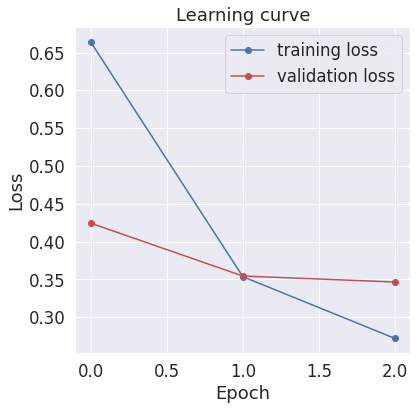

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (6,6)

# Plot the learning curve.
plt.plot(loss_values_nltk, 'b-o', label="training loss")
plt.plot(validation_loss_values_nltk, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Model Binary Aspect

In [36]:
# Model Structure
model_binary = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx_binary),
    output_attentions = False,
    output_hidden_states = False
)

# Hyperparameters for Fine Tuning
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model_binary.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model_binary.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(binary_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Store the average loss after each epoch
loss_values_binary, validation_loss_values_binary = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Put the model into training mode.
    model_binary.train()
    # Reset the total loss for each epoch.
    total_loss_binary = 0

    # Training loop
    for step, batch in enumerate(binary_dataloader):
        # Extrach inputs from the batch
        batch = tuple(t for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Clear any previously calculated gradients before performing a backward pass.
        model_binary.zero_grad()
        # Model
        outputs = model_binary(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Extract the train loss
        total_loss_binary += loss.item()
        # Clip the norm of the gradient
        # to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model_binary.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss_binary = total_loss_binary / len(binary_dataloader)
    print("binary Average train loss: {}".format(round(avg_train_loss_binary),5))

    # Store the loss value.
    loss_values_binary.append(avg_train_loss_binary)

    # ========================================
    #               Validation
    # ========================================
    # Put the model into evaluation mode
    model_binary.eval()
    # Reset the validation loss for each epoch
    eval_loss_binary, eval_accuracy_binary = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions_binary , true_labels_binary = [], []
    # Upload inputs from the batch
    for batch in binary_val_dataloader:
        batch = tuple(t for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():  #not compute or store gradients to speed up validation
            # Forward pass, calculate logit predictions.
            outputs_binary = model_binary(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Logits (for predictions)
        logits_binary = outputs_binary[1].numpy()
        label_ids_binary = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss_binary += outputs_binary[0].mean().item()
        predictions_binary.extend([list(p) for p in np.argmax(logits_binary, axis=2)])
        true_labels_binary.extend(label_ids_binary)

    eval_loss_binary = eval_loss_binary / len(binary_val_dataloader)
    validation_loss_values_binary.append(eval_loss_binary)
    print("binary Validation loss: {}".format(round(eval_loss_binary,5)))
    pred_tags_binary = [tag_values_binary[p_i] for p, l in zip(predictions_binary, true_labels_binary)
                                 for p_i, l_i in zip(p, l) if tag_values_binary[l_i] != "PAD"]
    valid_tags_binary  = [tag_values_binary[l_i] for l in true_labels_binary
                                  for l_i in l if tag_values_binary[l_i] != "PAD"]
    print()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

binary Average train loss: 0





Epoch:  33%|███▎      | 1/3 [02:22<04:44, 142.13s/it]

binary Validation loss: 0.13329

binary Average train loss: 0





Epoch:  67%|██████▋   | 2/3 [04:45<02:22, 142.59s/it]

binary Validation loss: 0.10522

binary Average train loss: 0





Epoch: 100%|██████████| 3/3 [07:11<00:00, 143.91s/it]

binary Validation loss: 0.10596



### Performance Graph

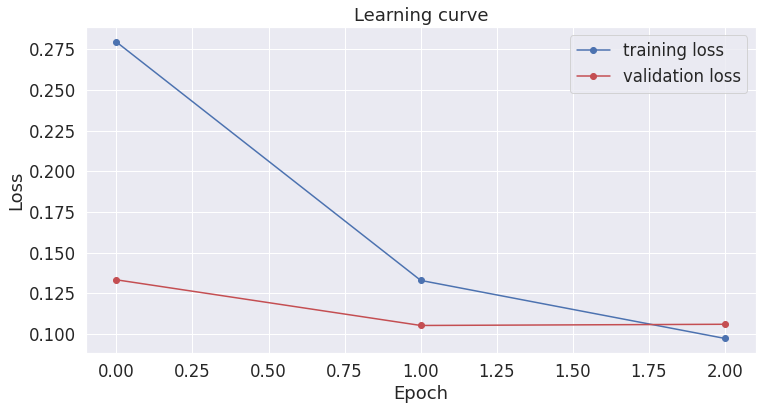

In [37]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values_binary, 'b-o', label="training loss")
plt.plot(validation_loss_values_binary, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Model IOB Aspect

In [39]:
# Model Structure
model_IOB = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx_IOB),
    output_attentions = False,
    output_hidden_states = False
)

# Hyperparameters for Fine Tuning
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model_IOB.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model_IOB.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(IOB_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Store the average loss after each epoch
loss_values_IOB, validation_loss_values_IOB = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Put the model into training mode.
    model_IOB.train()
    # Reset the total loss for each epoch.
    total_loss_IOB = 0

    # Training loop
    for step, batch in enumerate(IOB_dataloader):
        # Extrach inputs from the batch
        batch = tuple(t for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Clear any previously calculated gradients before performing a backward pass.
        model_IOB.zero_grad()
        # Model
        outputs = model_IOB(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Extract the train loss
        total_loss_IOB += loss.item()
        # Clip the norm of the gradient
        # to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model_IOB.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss_IOB = total_loss_IOB / len(IOB_dataloader)
    print("IOB Average train loss: {}".format(round(avg_train_loss_IOB),5))

    # Store the loss value.
    loss_values_IOB.append(avg_train_loss_IOB)

    # ========================================
    #               Validation
    # ========================================
    # Put the model into evaluation mode
    model_IOB.eval()
    # Reset the validation loss for each epoch
    eval_loss_IOB, eval_accuracy_IOB = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions_IOB , true_labels_IOB = [], []
    # Upload inputs from the batch
    for batch in IOB_val_dataloader:
        batch = tuple(t for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():  #not compute or store gradients to speed up validation
            # Forward pass, calculate logit predictions.
            outputs_IOB = model_IOB(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Logits (for predictions)
        logits_IOB = outputs_IOB[1].numpy()
        label_ids_IOB = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss_IOB += outputs_IOB[0].mean().item()
        predictions_IOB.extend([list(p) for p in np.argmax(logits_IOB, axis=2)])
        true_labels_IOB.extend(label_ids_IOB)

    eval_loss_IOB = eval_loss_IOB / len(IOB_val_dataloader)
    validation_loss_values_IOB.append(eval_loss_IOB)
    print("IOB Validation loss: {}".format(round(eval_loss_IOB,5)))
    pred_tags_IOB = [tag_values_IOB[p_i] for p, l in zip(predictions_IOB, true_labels_IOB)
                                 for p_i, l_i in zip(p, l) if tag_values_IOB[l_i] != "PAD"]
    valid_tags_IOB  = [tag_values_IOB[l_i] for l in true_labels_IOB
                                  for l_i in l if tag_values_IOB[l_i] != "PAD"]
    print()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

IOB Average train loss: 0






Epoch:  33%|███▎      | 1/3 [02:10<04:21, 130.83s/it]

IOB Validation loss: 0.19775

IOB Average train loss: 0






Epoch:  67%|██████▋   | 2/3 [04:26<02:12, 132.42s/it]

IOB Validation loss: 0.17083

IOB Average train loss: 0






Epoch: 100%|██████████| 3/3 [06:45<00:00, 135.02s/it]

IOB Validation loss: 0.1611



Performance Graph

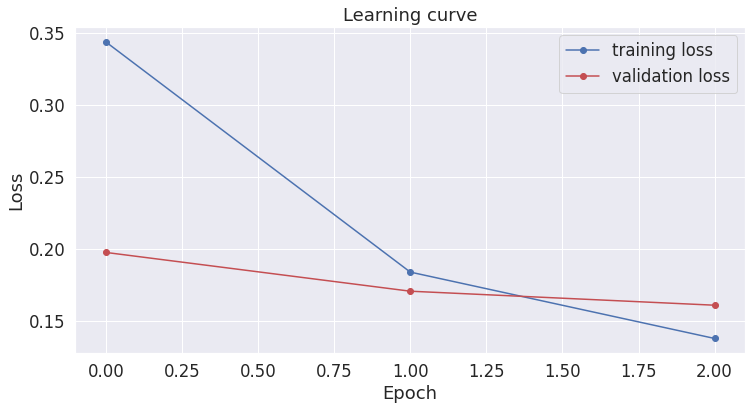

In [40]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values_IOB, 'b-o', label="training loss")
plt.plot(validation_loss_values_IOB, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Evaluation

### Data Processing

#### Tagging for Test

In [41]:
# nltk
test_df.Text = test_df.Text.astype('str')
sample_test = test_df.Text[0]
sent_test = preprocess(sample_test)

cs_test = cp.parse(sent_test)
iob_tagged_test = tree2conlltags(cs_test)
df_sample_test = pd.DataFrame(iob_tagged_test, columns = ['Word', 'POS', 'nltkTag'])
df_sample_test.insert(0, 'Sentence #', 0+1)

for i in range(len(test_df.Text)-1):
  sample = test_df.Text[i+1]
  sent = preprocess(sample)
  cs = cp.parse(sent)
  iob_tagged = tree2conlltags(cs)
  other_samples = pd.DataFrame(iob_tagged, columns = ['Word', 'POS', 'nltkTag'])
  other_samples.insert(0, 'Sentence #', i+2)
  df_sample_test = pd.concat([df_sample_test, other_samples], axis=0)

df_sample_test = df_sample_test.reset_index(drop = True)
df_sample_test

,Sentence #,Word,POS,nltkTag
0,1,yum,NN,B-NP
1,2,serves,NNS,O
2,2,really,RB,O
3,2,good,JJ,B-NP
4,2,sushi,NN,I-NP
...,...,...,...,...
7377,587,yeahthe,NN,B-NP
7378,587,view,NN,B-NP
7379,587,was,VBD,O
7380,587,good,JJ,O


In [42]:
# binary 
tokenized_sentences_test = []
for i in range(len(test_df.Text)):
  sent_test = nltk.word_tokenize(test_df.Text[i])
  tokenized_sentences_test.append(sent_test)
  
aspect_list_test = []
for i in range((max(test.Sentence_ID))):
    if any(test.Sentence_ID == i+1) == True:
      aspect_list_test.append(test.groupby(['Sentence_ID']).get_group(i+1).AspectTerm.values)

for i in range(len(aspect_list_test)):
  if aspect_list_test[i] == []:
    aspect_list_test[i] = aspect_list_test[i]
  else:
    aspect_list_test[i] = [nltk.word_tokenize(j) for j in aspect_list_test[i]]

for i in range(len(aspect_list_test)):
  aspect_list_test[i] = [item for sublist in aspect_list_test[i] for item in sublist]
  aspect_list_test

aspect_labels_test = []
for token in tokenized_sentences_test[0]:
  if np.isin(token, aspect_list_test[0]) == True:
    aspect_labels_test.append(1)
  else:
    aspect_labels_test.append(0)

other_aspects_test = []
for i in range(len(tokenized_sentences_test)-1):
  for token in tokenized_sentences_test[i+1]:
    if np.isin(token, aspect_list_test[i+1]) == True:
      other_aspects_test.append(1)
    else:
      other_aspects_test.append(0)
aspect_labels_test = pd.concat([pd.Series(aspect_labels_test), pd.Series(other_aspects_test)], axis=0)
aspect_labels_test = aspect_labels_test.reset_index(drop=True)
df_sample_test['binary_AspectTags'] = aspect_labels_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


In [43]:
# IOB
BIO_aspectTags_test = pd.Series(aspect_labels_test)
BIO_aspectTags_test = BIO_aspectTags_test.replace(to_replace=0, value='O')
BIO_aspectTags_test = BIO_aspectTags_test.replace(to_replace=1, value='B-NP')

deneme_list_test = BIO_aspectTags_test.values.tolist()
gizem_test =[]
for n in range(len(deneme_list_test)):
  if (deneme_list_test[n] != deneme_list_test[-1] and deneme_list_test[n] == 'O' and deneme_list_test[n+1] =='B-NP'):
    gizem_test.append('B-NP')
  elif (deneme_list_test[n-1] == 'O' and deneme_list_test[n] == 'B-NP' and deneme_list_test[n+1] =='B-NP'):
    gizem_test.append('B-NP')
  elif (deneme_list_test[n-1] == 'B-NP' and deneme_list_test[n] == 'B-NP' and deneme_list_test[n+1] =='B-NP'):
    gizem_test.append('I-NP')
  elif (deneme_list_test[n-1] == 'B-NP' and deneme_list_test[n] == 'B-NP' and deneme_list_test[n+1] =='O'):
    gizem_test.append('I-NP')   
  else:
    gizem_test.append(deneme_list_test[n])

df_sample_test['BIO_aspectTags'] = pd.Series(gizem_test)
df_sample_test[7350:7382]

,Sentence #,Word,POS,nltkTag,binary_AspectTags,BIO_aspectTags
7350,586,while,IN,O,0,O
7351,586,i,NN,B-NP,0,O
7352,586,could,MD,O,0,O
7353,586,have,VB,O,0,O
7354,586,done,VBN,O,0,O
7355,586,without,IN,O,0,O
7356,586,the,DT,B-NP,0,O
7357,586,youth,NN,I-NP,0,O
7358,586,who,WP,O,0,O
7359,586,shared,VBD,O,0,O


#### Bert Tokenization for Test

In [44]:
grouped_df_test = df_sample_test.groupby("Sentence #").apply(agg_func)
sentences_test = [[word[0] for word in sentence] for sentence in grouped_df_test]
ntlkTags_test = [[tag[1] for tag in sentence] for sentence in grouped_df_test]
binary_AspectTags_test = [[tag[2] for tag in sentence] for sentence in grouped_df_test]
BIO_aspectTags_test = [[tag[3] for tag in sentence] for sentence in grouped_df_test]

In [45]:
# nltk
all_sentence_list_nltk_test = []
all_label_list_nltk_test = []
for i in range(len(sentences_test)):
  tokenized_sentence_list = []
  label_list = []
  for word, label in zip(sentences_test[i], ntlkTags[i]):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentence_list.extend(tokenized_word)
    label_list.extend([label] * n_subwords)
  all_sentence_list_nltk_test.append(tokenized_sentence_list)
  all_label_list_nltk_test.append(label_list)

# Raw Inputs
tokenized_texts = all_sentence_list_nltk_test
labels = all_label_list_nltk_test

# Max length
max_length = max([len(sen) for sen in tokenized_texts])

input_ids_nltk_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_length, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_nltk_test = pad_sequences([[tag2idx_nltk.get(l) for l in lab] for lab in labels],
                     maxlen=max_length, value=tag2idx_nltk["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_nltk_test = [[float(i != 0.0) for i in ii] for ii in input_ids_nltk_test]
input_ids_nltk_test[0], tags_nltk_test[0]

(array([ 194, 1818,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]),
 array([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [46]:
# binary
all_sentence_list_binary_test = []
all_label_list_binary_test = []
for i in range(len(sentences_test)):
  tokenized_sentence_list = []
  label_list = []
  for word, label in zip(sentences_test[i], binary_AspectTags_test[i]):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentence_list.extend(tokenized_word)
    label_list.extend([label] * n_subwords)
  all_sentence_list_binary_test.append(tokenized_sentence_list)
  all_label_list_binary_test.append(label_list)

# Raw Inputs
tokenized_texts_binary_test = all_sentence_list_binary_test
labels_binary_test = all_label_list_binary_test

# Max length
max_length_binary_test = max([len(sen) for sen in tokenized_texts_binary_test])

input_ids_binary_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_binary_test],
                          maxlen=max_length_binary_test, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_binary_test = pad_sequences([[tag2idx_binary.get(l) for l in lab] for lab in labels_binary_test],
                     maxlen=max_length, value=tag2idx_binary["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_binary_test = [[float(i != 0.0) for i in ii] for ii in input_ids_binary_test]
input_ids_binary_test[0], tags_binary_test[0]

(array([ 194, 1818,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]),
 array([0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [47]:
# IOB
all_sentence_list_IOB_test = []
all_label_list_IOB_test = []
for i in range(len(sentences_test)):
  tokenized_sentence_list = []
  label_list = []
  for word, label in zip(sentences_test[i], BIO_aspectTags_test[i]):
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    tokenized_sentence_list.extend(tokenized_word)
    label_list.extend([label] * n_subwords)
  all_sentence_list_IOB_test.append(tokenized_sentence_list)
  all_label_list_IOB_test.append(label_list)

# Raw Inputs
tokenized_texts_IOB_test = all_sentence_list_IOB_test
labels_IOB_test = all_label_list_IOB_test

# Max length
max_length_IOB_test = max([len(sen) for sen in tokenized_texts_IOB_test])

input_ids_IOB_test= pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_IOB_test],
                          maxlen=max_length_IOB_test, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags_IOB_test = pad_sequences([[tag2idx_IOB.get(l) for l in lab] for lab in labels_IOB_test],
                     maxlen=max_length, value=tag2idx_IOB["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks_IOB_test = [[float(i != 0.0) for i in ii] for ii in input_ids_IOB_test]
input_ids_IOB_test[0], tags_IOB_test[0]

(array([ 194, 1818,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]),
 array([2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

### Predictions

In [48]:
# nltk
test_Text = test_Text.reset_index(drop = True)
data_list_nltk, all_predictions_nltk = [], []
for i in range(len(test_Text)):
  tkns = tokenizer.tokenize(test_Text[i])
  indexed_tokens = tokenizer.convert_tokens_to_ids(tkns)
  segments_ids = [0] * len(tkns)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  model_nltk.eval()
  with torch.no_grad():
    prediction_nltk = []
    output_test = model_nltk(tokens_tensor, token_type_ids=None,
                      attention_mask=segments_tensors)
    logit = output_test[0].numpy()
  prediction_nltk.extend(p for p in np.argmax(logit, axis=2))
  prediction_nltk = list(prediction_nltk[0])

  new_tokens_nltk, new_labels_nltk = [], []
  for token, label in zip(tkns, prediction_nltk):
    if token.startswith("##"):
      new_tokens_nltk[-1] = new_tokens_nltk[-1] + token[2:]
    else:
      new_tokens_nltk.append(token)
      new_labels_nltk.append(label)
    df_sentence_nltk = pd.DataFrame({'tokens':pd.Series(new_tokens_nltk), 'tags':pd.Series(new_labels_nltk)})
  all_predictions_nltk.append(new_labels_nltk)
  data_list_nltk.append(df_sentence_nltk) 

In [49]:
# binary
test_Text = test_Text.reset_index(drop = True)
data_list_binary, all_predictions_binary = [], []
for i in range(len(test_Text)):
  tkns = tokenizer.tokenize(test_Text[i])
  indexed_tokens = tokenizer.convert_tokens_to_ids(tkns)
  segments_ids = [0] * len(tkns)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  model_binary.eval()
  with torch.no_grad():
    prediction_binary = []
    output_test = model_binary(tokens_tensor, token_type_ids=None,
                      attention_mask=segments_tensors)
    logit = output_test[0].numpy()
  prediction_binary.extend(p for p in np.argmax(logit, axis=2))
  prediction_binary = list(prediction_binary[0])

  new_tokens_binary, new_labels_binary = [], []
  for token, label in zip(tkns, prediction_binary):
    if token.startswith("##"):
      new_tokens_binary[-1] = new_tokens_binary[-1] + token[2:]
    else:
      new_tokens_binary.append(token)
      new_labels_binary.append(label)
    df_sentence_binary = pd.DataFrame({'tokens':pd.Series(new_tokens_binary), 'tags':pd.Series(new_labels_binary)})
  all_predictions_binary.append(new_labels_binary)
  data_list_binary.append(df_sentence_binary) 

In [50]:
# IOB
test_Text = test_Text.reset_index(drop = True)
data_list_IOB, all_predictions_IOB = [], []
for i in range(len(test_Text)):
  tkns = tokenizer.tokenize(test_Text[i])
  indexed_tokens = tokenizer.convert_tokens_to_ids(tkns)
  segments_ids = [0] * len(tkns)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])

  model_IOB.eval()
  with torch.no_grad():
    prediction_IOB = []
    output_test = model_IOB(tokens_tensor, token_type_ids=None,
                      attention_mask=segments_tensors)
    logit = output_test[0].numpy()
  prediction_IOB.extend(p for p in np.argmax(logit, axis=2))
  prediction_IOB = list(prediction_IOB[0])

  new_tokens_IOB, new_labels_IOB = [], []
  for token, label in zip(tkns, prediction_IOB):
    if token.startswith("##"):
      new_tokens_IOB[-1] = new_tokens_IOB[-1] + token[2:]
    elif token.startswith("'"):   
      new_tokens_IOB[-1] = new_tokens_IOB[-1] + token
    else:
      new_tokens_IOB.append(token)
      new_labels_IOB.append(label)
    df_sentence_IOB = pd.DataFrame({'tokens':pd.Series(new_tokens_IOB), 'tags':pd.Series(new_labels_IOB)})
  all_predictions_IOB.append(new_labels_IOB)
  data_list_IOB.append(df_sentence_IOB) 

### F1 Score & Accuracy & Classification Report

In [51]:
tag2idx_nltk, tag2idx_binary, tag2idx_IOB

({'B-NP': 1, 'I-NP': 0, 'O': 2, 'PAD': 3},
 {0: 0, 1: 1, 'PAD': 2},
 {'B-NP': 1, 'I-NP': 0, 'O': 2, 'PAD': 3})

In [52]:
# nltk
for j in range(len(all_predictions_nltk)):
  for n, i in enumerate(all_predictions_nltk[j]):
    if i == 0:
      all_predictions_nltk[j][n] = 'I-NP'
    elif i == 1:
      all_predictions_nltk[j][n] = 'B-NP'
    else:
      all_predictions_nltk[j][n] = 'O'
true_labels_nltk = ntlkTags_test[:]

# binary
true_labels_binary = binary_AspectTags_test[:]

# IOB
for j in range(len(all_predictions_IOB)):
  for n, i in enumerate(all_predictions_IOB[j]):
    if i == 0:
      all_predictions_IOB[j][n] = 'I-NP'
    elif i == 1:
      all_predictions_IOB[j][n] = 'B-NP'
    else:
      all_predictions_IOB[j][n] = 'O'
true_labels_IOB = BIO_aspectTags_test[:]

### Output Frame

In [55]:
aspectTerm_nltk, aspectTerm_binary, aspectTerm_IOB = [], [], []
for i in range(len(test_Text)):
  aspectTerm_nltk.append(data_list_nltk[i].loc[data_list_nltk[i]['tags'].isin([1,0])].tokens.values)
  aspectTerm_binary.append(data_list_binary[i].loc[data_list_binary[i]['tags'].isin([1])].tokens.values)
  aspectTerm_IOB.append(data_list_IOB[i].loc[data_list_IOB[i]['tags'].isin([1,0])].tokens.values)
  
output_frame = pd.merge(test_df, pd.DataFrame({'aspectTerm_nltk': pd.Series(aspectTerm_nltk)}), 
                        left_index = True, right_index=True)
output_frame = pd.merge(output_frame, pd.DataFrame({'aspectTerm_binary': pd.Series(aspectTerm_binary)}), 
                        left_index = True, right_index=True)
output_frame = pd.merge(output_frame, pd.DataFrame({'aspectTerm_IOB': pd.Series(aspectTerm_IOB)}), 
                        left_index = True, right_index=True)
output_frame

,Text,aspectTerms,aspectTerm_nltk,aspectTerm_binary,aspectTerm_IOB
0,yum,[],[],[],[]
1,serves really good sushi,[sushi],[sushi],[sushi],[sushi]
2,not the biggest portions but adequate,[portions],[],[portions],[]
3,green tea creme brulee is a must,[Green Tea creme brulee],"[Green, Tea, creme, brulee, a, must]","[Tea, creme, brulee]","[Tea, creme, brulee]"
4,do not leave the restaurant without it,[],"[the, restaurant]",[],[]
...,...,...,...,...,...
582,our server continued to be attentive throughou...,"[server, Ray's]","[server, the, night, one, issue, Ray, s, an, a...",[server],[server]
583,two rascally kids were seated near us for the ...,[],"[the, first, part, dinner, a, delightful, pret...",[],[]
584,all considered i have to say that rays boathou...,[Ray's Boathouse],"[Ray, s, Boathouse, title, a, Seattle, institu...",[Boathouse],[Boathouse]
585,while i could have done without the youth who ...,"[food, , server]","[the, youth, the, evening, wonderful, server, ...","[server, food]","[server, food]"


In [ ]:
output_frame.to_excel('OutputFrame_NER.xlsx')
output_frame.to_csv('OutputFrame_NER.csv')